# BatchNormalization(Pytorch)

在这里我们将使用Pytorch来实现BN网络并与普通Base Lines进行比较.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
from miniBatch import random_mini_batche  
from data_utils import get_CIFAR10_data

### Load Data

这里我们加载CIFAR10数据集,由于电脑限制原因,我们这里只使用2000个样本.

In [2]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [3]:
def load_data(index_train,index_val,index_test):
    """
    Load data set
    
    Parameters:
    ----------
       index_train: training set index range.
       index_val: val data set index range.
       index_test : test data set index range.
    
    Returns:
    -------
       train_x: train set data
       train_y train set labels
       val_x: val set data
       val_y: val set labels
       test_x: test set data
       test_y: test set labels.
    """
    train_x = data['X_train'][:index_train].reshape(index_train,-1)
    train_y = data['y_train'][:index_train]
    
    val_x = data['X_val'][:index_val].reshape(index_val,-1)
    val_y = data['y_val'][:index_val]
    
    test_x = data['X_test'][:index_test].reshape(index_test,-1)
    test_y = data['y_test'][:index_test]
    
    return train_x,train_y,val_x,val_y,test_x,test_y

In [4]:
train_x,train_y,val_x,val_y,test_x,test_y = load_data(2000,100,100)

### Build Pytorch of BN

这里有几个需要注意的地方

[1]

```python
def __init__(self,layers,mode):
    ...```
    
(1.1) 在此函数中,由于我们是多层网络,所以需要使用for loop统一创建,但是如果只是使用for loop,那么在后面更新的时候,Pytorch会报出```model.parameters()```为空的情况,为了解决这种情况我们需要使用```ModeleList```来将所有的模型装入,当然也可以选择其他模式,具体请查看[nn.Model](https://pytorch.org/docs/stable/nn.html#module),包括可以使用```ModelDict```等.同样,由于我们这里是比较BN与BL,所以BN也是需要装入```ModelList```的.

(1.2) 我们可以使用```[nn.init.xavier_normal_(line.weight) for line in self.lines]```来改变```nn.Linear```中的weights初始化值.

(1.3) 我们可以使用```model.children()```来查看当前模型下的所有子模型.可以用来查看当前模型是否正确.

(1.4) 这里也可以使用```nn.Sequential()```和```model.add_model```等方式来增加Linear和BatchNormal layers.

[2]

```python
def forward(self,x):
    ...```
    
对于forward而言,就是把当前层拿出来计算就可以了,需要注意的是,我们的X是需要计算反向的,也就是说对于以前版本而言```Variable(volatile=True)```.现在```volatile=True```等价于```with torch.no_grad():```.一般我们在测试的时候才需要指定.

[3]

```Python
def train(model,batchs,Loss_fuc,optimizer):
    ...```
    
(3.1) 由于我们选择的损失函数为```nn.CrossEntropyLoss()```,此损失函数是经常用于多分类的,实际上在Pytorch中该损失函数就是```Logsoftmax```和```NLLLosse```的组合,详情请查看[nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html#crossentropyloss).

(3.2) 并且该损失函数的target是要指定tensor类型为Longe,所以我们需要将labels转换为该类型```mini_y_tensor = Variable(torch.Tensor(mini_y)).long()```

(3.3) 由于我们如果使用BN网络,那么在训练阶段和测试阶段使用的scale和shift是不一样的,训练阶段我们使用每一个batch size的$\mu,\sigma^{2}$,但是在测试阶段,我们是使用滑动平均和滑动方差(running mean/running var).Pytorch提供了以下方法来控制我们是训练还是测试

(3.3.1) ```model.train()```:训练模式[nn.Model.train](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.train)

(3.3.2) ```model.eval()```:锁定所有参数(即为测试模式),[nn.Model.eval](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.eval)

[4]

```python
def score(model,score_data,score_labels):
    ...```
    
在此函数中,我们需要指定```model.eval()```来锁定参数,进而进入BN的测试模式.另外由于forward函数返回的值还没有经过softmax处理,所以我们需要使用```F.softmax(out,dim=1)```并指定特征轴```dim=1```来进行计算softmax value.


[5]

```python

def Model_(data,labels,val_data,val_labels,batch_size,layers,epochs,lr,mode):
    ...```
    
    
(5.1) 由于在测试阶段,我们不需要计算图来反向计算数据,所以我们可以使用```with torch.no_grad():```来加速计算.这一步是十分必要的,这一步即相当于Pytorch早期版本的```Variable(volatile=True)```.


(5.2) 整体流程为:

>1.预备工作

>2.初始化在测试阶段的数据

>3.建立Loss_func,这里使用(也是最常用)``nn.CrossEntropyLoss()``

>4.建立optimizer,这里使用的是SGD

>5.开始训练,每100步打印当前的loss和训练样本的正确率与验证集的正确率

>5.返回每100步的loss,训练集的正确率,验证集的正确率.

In [29]:
class BN_Base_Model(nn.Module):
    """
    Build Batch Normalization and Base Line Neural Network.
    """
    def __init__(self,layers,mode):
        """
        initialization some parameters.
        Parameters:
        ---------
            layers: NN layers. This sample is [100,80,50,30,10]
            mode: is BN or BL,BN: Batch Normalization BL: Base Lines.
        """
        nn.Module.__init__(self)
        self.layers = layers
        self.L = len(layers)
        self.mode = mode
        
        # choose BN NN or BL NN
        if self.mode == 'BN':
            self.lines = nn.ModuleList([nn.Linear(self.layers[l],self.layers[l+1]) for l in range(self.L-1)])
            self.bns = nn.ModuleList([nn.BatchNorm1d(self.layers[l+1]) for l in range(self.L-1)])
        elif self.mode == "BL":
            self.lines = nn.ModuleList([nn.Linear(self.layers[l],self.layers[l+1]) for l in range(self.L-1)])
        else:
            print('Valid mode %s'%self.mode)
            exit(0)
        # change the default weights initialze value to xvaier.
        [nn.init.xavier_normal_(line.weight) for line in self.lines]
                               
    def forward(self,x):
        """
        Build forward propagation.
        
        Parameter:
        ---------
            x: training data
        Return:
        ------
            x: The last layer value.
        """
        if self.mode == "BN":
            for l in range(self.L-1):
                x = self.lines[l](x)
                x = self.bns[l](x)
                if l != self.L -2:
                    x = F.relu(x) # using relu activation function
                else:
                    return x # output layer.
        else:
            for l in range(self.L-1):
                x = self.lines[l](x)
                if l != self.L-2:
                    x = F.relu(x)
                else:
                    return x

In [34]:
def train(model,batchs,Loss_fuc,optimizer):
    """
    Training model.
    Parameters:
    ----------
       model: Pytorch NN model.
       batchs: random mini-batchs result.
       Loss_fuc: NN loss function.
       optimizer : NN optimizer.
    
    Return:
    ------
        loss: The loss function
    """
    model.train() # change mode status is train,Very importent in BN or Dropout.
    for mini_x,mini_y in batchs:
        mini_x_tensor = Variable(torch.Tensor(mini_x))
        mini_y_tensor = Variable(torch.Tensor(mini_y)).long()
        out = model.forward(mini_x_tensor)
        
        loss = Loss_fuc(out,mini_y_tensor)
        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return loss

In [35]:
def score(model,score_data,score_labels):
    """
    score this model.
    
    Parameters:
    ----------
        model: Pytorch NN model.
        score_data: score data.
        score_labels: score labels
    """
    m,n = score_data.shape
    model.eval() # change mode status is eval,Very importent in BN or Dropout.
    out = model.forward(score_data)
    out = F.softmax(out,dim=1) # using softmax.
    predict_y = torch.argmax(out,dim=1) # get predict value.
    acc = torch.eq(predict_y,score_labels).sum().item() / m
    return acc

In [36]:
def Model_(data,labels,val_data,val_labels,batch_size,layers,epochs,lr,mode):
    """
    Build Model.
    
    Parameters:
    ----------
        data: training data.
        labels: training labels.
        val_data: val data.
        val_labels: val labels.
        batch_size: batch size in random mini-batch. default size: 64
        layers: NN layers,this model using [100,80,50,30,10]
        epochs: #Iter
        lr: learning rate.
        mode: is Batch Normalizetion or Balse Line.
    Returns:
    -------
        costs: loss value at 100 step.
        acc_trains: train accuracy at 100step. 
        acc_vals. val accuracy at 100 step.
    """
    m,n = data.shape
    n_classes = len(np.unique(labels))
    layers.insert(0,n)
    
    # In testing mode, we did not caculate data or label grad,so set no grad.
    with torch.no_grad():
        data_tensor = Variable(torch.from_numpy(data)).float()
        labels_tensor = Variable(torch.from_numpy(labels))
        val_data_tensor = Variable(torch.from_numpy(val_data)).float()
        val_labels_tensor = Variable(torch.from_numpy(val_labels))
        
    model = BN_Base_Model(layers,mode) # build torch model.
    
    Loss_fuc = nn.CrossEntropyLoss() # create loss, this loss equal logsoftamx + Nllloss.
    optimizer = torch.optim.SGD(model.parameters(),lr=lr) # using SGD optimizer.
    
    seed = 0
    costs = []
    acc_trains = []
    acc_vals = []
    # start training ...
    for epoch in range(epochs):
        seed += 1
        batchs = random_mini_batche(data,labels,mini_batche_size=batch_size,seed=seed)
        loss = train(model,batchs,Loss_fuc,optimizer)
        
        if epoch % 100 == 0:
            acc_train = score(model,data_tensor,labels_tensor)
            acc_val = score(model,val_data_tensor,val_labels_tensor)
            print('After [{}/{}] loss:{} acc train:{} acc val:{}'.format(epoch+100,epochs,loss,acc_train,acc_val))
            costs.append(loss)
            acc_trains.append(acc_train)
            acc_vals.append(acc_val)
            
    return costs,acc_trains,acc_vals


### Testing BN and BaseLine

测试不同情况下,BN网络与普通网络之间的差异:

(1) 小权重,小学习率

(2) 小权重,大学习率

In [37]:
def plot_(costs_bn,costs,cache_acc_train_bn,cache_acc_train,cache_acc_val_bn,cache_acc_val):
    fig=plt.figure(figsize=(20,4))
    ax1=fig.add_subplot(1,3,1)      
    ax1.plot(costs_bn,c='orange',label='batch normal')
    ax1.plot(costs,label='base line')
    ax1.set_title('Loss:batch normal & base line')
    ax1.set_xlabel('#epoch')
    ax1.set_ylabel('Value')
    ax1.legend()

    ax2 =fig.add_subplot(1,3,2)      
    ax2.plot(cache_acc_train_bn,c='orange',label='batch normal')
    ax2.plot(cache_acc_train,label='base line')
    ax2.set_title('Train acc:batch normal & base line')
    ax2.set_xlabel('#epoch')
    ax2.set_ylabel('Value')
    ax2.legend()

    ax3 =fig.add_subplot(1,3,3)      
    ax3.plot(cache_acc_val_bn,c='orange',label='batch normal')
    ax3.plot(cache_acc_val,label='base line')
    ax3.set_title('Val acc:batch normal & base line')
    ax3.set_xlabel('#epoch')
    ax3.set_ylabel('Value')
    ax3.legend()

    plt.show()

#### 小权重,小学习率

In [42]:
layers = [100, 80,50,30,10]
costs_bn,cache_acc_train_bn,cache_acc_val_bn = Model_(data=train_x,labels=train_y,val_data=val_x,val_labels=val_y,
       batch_size=32,layers=layers,epochs=1000,lr=0.001,mode="BN")

After [100/1000] loss:2.142920970916748 acc train:0.1555 acc val:0.13
After [200/1000] loss:1.5122568607330322 acc train:0.8105 acc val:0.37
After [300/1000] loss:0.7360067963600159 acc train:0.9385 acc val:0.32
After [400/1000] loss:0.6530070304870605 acc train:0.9905 acc val:0.31
After [500/1000] loss:0.8915790319442749 acc train:0.998 acc val:0.32
After [600/1000] loss:0.24508029222488403 acc train:1.0 acc val:0.29
After [700/1000] loss:0.3348768353462219 acc train:1.0 acc val:0.28
After [800/1000] loss:0.5815497636795044 acc train:1.0 acc val:0.3
After [900/1000] loss:0.20104311406612396 acc train:1.0 acc val:0.28
After [1000/1000] loss:0.3199479281902313 acc train:1.0 acc val:0.31


In [43]:
layers = [100, 80,50,30,10]
costs,cache_acc_train,cache_acc_val = Model_(data=train_x,labels=train_y,val_data=val_x,val_labels=val_y,
       batch_size=32,layers=layers,epochs=1000,lr=0.001,mode="BL")

After [100/1000] loss:5.619577884674072 acc train:0.2285 acc val:0.15
After [200/1000] loss:0.08663219213485718 acc train:0.9075 acc val:0.25
After [300/1000] loss:0.3730923533439636 acc train:0.943 acc val:0.23
After [400/1000] loss:0.011909127235412598 acc train:0.9795 acc val:0.28
After [500/1000] loss:0.018414169549942017 acc train:0.986 acc val:0.29
After [600/1000] loss:0.004065454006195068 acc train:0.993 acc val:0.3
After [700/1000] loss:0.001047670841217041 acc train:0.994 acc val:0.31
After [800/1000] loss:0.0013194680213928223 acc train:0.995 acc val:0.31
After [900/1000] loss:0.0002416372299194336 acc train:0.995 acc val:0.29
After [1000/1000] loss:0.15627922117710114 acc train:0.995 acc val:0.29


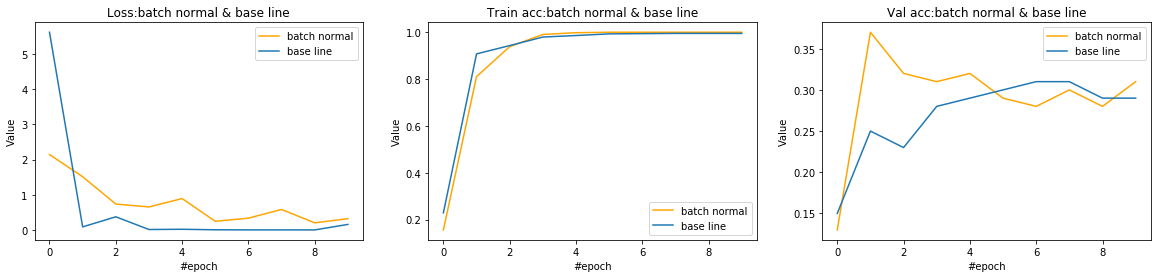

In [46]:
plot_(costs_bn,costs,cache_acc_train_bn,cache_acc_train,cache_acc_val_bn,cache_acc_val)

#### 小权重,大学习率

In [47]:
layers = [100, 80,50,30,10]
costs_bn,cache_acc_train_bn,cache_acc_val_bn = Model_(data=train_x,labels=train_y,val_data=val_x,val_labels=val_y,
       batch_size=32,layers=layers,epochs=1000,lr=0.1,mode="BN")

After [100/1000] loss:1.8307554721832275 acc train:0.3165 acc val:0.35
After [200/1000] loss:0.21524980664253235 acc train:0.9935 acc val:0.37
After [300/1000] loss:0.03593246638774872 acc train:1.0 acc val:0.34
After [400/1000] loss:0.07386665046215057 acc train:1.0 acc val:0.39
After [500/1000] loss:0.0435338169336319 acc train:1.0 acc val:0.38
After [600/1000] loss:0.015196077525615692 acc train:1.0 acc val:0.36
After [700/1000] loss:0.18543443083763123 acc train:1.0 acc val:0.36
After [800/1000] loss:0.008809760212898254 acc train:1.0 acc val:0.4
After [900/1000] loss:0.010225176811218262 acc train:1.0 acc val:0.42
After [1000/1000] loss:0.012865602970123291 acc train:1.0 acc val:0.4


In [48]:
layers = [100, 80,50,30,10]
costs,cache_acc_train,cache_acc_val = Model_(data=train_x,labels=train_y,val_data=val_x,val_labels=val_y,
       batch_size=32,layers=layers,epochs=1000,lr=0.1,mode="BL")

After [100/1000] loss:nan acc train:0.101 acc val:0.07
After [200/1000] loss:nan acc train:0.101 acc val:0.07
After [300/1000] loss:nan acc train:0.101 acc val:0.07
After [400/1000] loss:nan acc train:0.101 acc val:0.07
After [500/1000] loss:nan acc train:0.101 acc val:0.07
After [600/1000] loss:nan acc train:0.101 acc val:0.07
After [700/1000] loss:nan acc train:0.101 acc val:0.07
After [800/1000] loss:nan acc train:0.101 acc val:0.07
After [900/1000] loss:nan acc train:0.101 acc val:0.07
After [1000/1000] loss:nan acc train:0.101 acc val:0.07


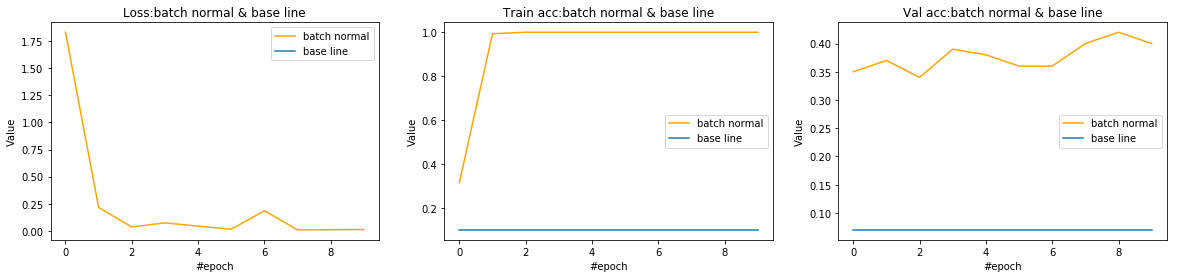

In [49]:
plot_(costs_bn,costs,cache_acc_train_bn,cache_acc_train,cache_acc_val_bn,cache_acc_val)

### Summary

总体而言Batch Normalization的效果会比普通Base Line的效果好许多.在大学习率下普通的BL会出现梯度消失/爆炸的情况,而BN网络则依然能够接受.